In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.integrate import quad
from scipy.interpolate import interp1d

def concatenate_columns(df):
    return df.values.flatten()

def compute_second_derivative_integral(x, y):
    if np.any(np.diff(x) <= 0):
        print("skip")
        return np.nan

    
    y_savgol_second_derivative = savgol_filter(y, window_length=min(31, len(y) - 1), polyorder=3, deriv=2)

    
    integral, _ = quad(lambda eps: np.interp(eps, x, np.abs(y_savgol_second_derivative) ** (2/5)), np.min(x), np.max(x))
    return integral ** (5/2)


def compute_optimal_segments(x, y, tau=5e-6):
    integral_value = compute_second_derivative_integral(x, y)
    if np.isnan(integral_value):
        return np.nan
    K = np.sqrt(integral_value / (np.sqrt(120) * tau))
    return int(np.ceil(K))


def compute_cumulative_distribution(x, y):
    y_savgol_second_derivative = savgol_filter(y, window_length=min(31, len(y) - 1), polyorder=3, deriv=2)
    
    denominator, _ = quad(lambda eps: np.interp(eps, x, np.abs(y_savgol_second_derivative) ** (2/5)), np.min(x), np.max(x))
    
    
    F_epsilon = np.zeros_like(x)
    for i, eps in enumerate(x):
        numerator, _ = quad(lambda e: np.interp(e, x, np.abs(y_savgol_second_derivative) ** (2/5)), np.min(x), eps)
        F_epsilon[i] = numerator / denominator
    
    return F_epsilon


def compute_breakpoints(x, y, K):
    if np.isnan(K) or K <= 1:
        return []

    F_epsilon = compute_cumulative_distribution(x, y)

    
    F_interp = interp1d(F_epsilon, x, kind="linear", bounds_error=False, fill_value=(x.min(), x.max()))

    
    breakpoints = F_interp(np.linspace(0, 1, K + 1)[1:-1])  
    return breakpoints


def process_hour(load_variation_dir, hour_dir, hour, output_dir):
    
    load_variation_file = os.path.join(load_variation_dir, f'load_variation_divided_{hour}.csv')
    if not os.path.exists(load_variation_file):
        print(f"file {load_variation_file} skip")
        return None
    load_variation_data = pd.read_csv(load_variation_file)
    x = np.array(concatenate_columns(load_variation_data))

    
    cost_differences_file = os.path.join(hour_dir, str(hour), 'divided_costs.csv')
    if not os.path.exists(cost_differences_file):
        print(f"file {cost_differences_file} skip")
        return None
    cost_differences_data = pd.read_csv(cost_differences_file)
    y = np.array(concatenate_columns(cost_differences_data))

    
    sort_indices = np.argsort(x)
    x_sorted = x[sort_indices]
    y_sorted = y[sort_indices]
    x_sorted, unique_indices = np.unique(x_sorted, return_index=True)
    y_sorted = y_sorted[unique_indices]

    
    y_savgol_smooth = savgol_filter(y_sorted, window_length=min(31, len(y_sorted) - 1), polyorder=3)

    
    if len(x_sorted) > 3:
        K_opt = compute_optimal_segments(x_sorted, y_savgol_smooth, tau=5e-6)
    else:
        K_opt = np.nan

    
    breakpoints = compute_breakpoints(x_sorted, y_savgol_smooth, K_opt)

    
    # F_epsilon = compute_cumulative_distribution(x_sorted, y_savgol_smooth)
    # plt.figure(figsize=(10, 6))
    # plt.plot(x_sorted, F_epsilon, color='blue', label='$F(\\epsilon)$')
    # for bp in breakpoints:
    #     plt.axvline(x=bp, color='green', linestyle='--')  # 画出分段点
    # plt.title(f'Hour {hour} - Cumulative Distribution Function')
    # plt.xlabel('$\\epsilon$')
    # plt.ylabel('$F(\\epsilon)$')
    # plt.legend()
    # plt.grid(True)
    # plt.savefig(os.path.join(output_dir, f'hour_{hour}_cumulative_distribution.png'))
    # plt.close()

    
    # plt.figure(figsize=(10, 6))
    # plt.plot(x_sorted, y_savgol_smooth, color='red', label='Smoothing spline')
    # plt.scatter(breakpoints, np.interp(breakpoints, x_sorted, y_savgol_smooth), color='black', marker='D', label='Breakpoints')
    # plt.title(f'Hour {hour} - Smoothing Spline and Breakpoints')
    # plt.xlabel('$\\epsilon$')
    # plt.ylabel('$S(\\epsilon)$')
    # plt.legend()
    # plt.grid(True)
    # plt.savefig(os.path.join(output_dir, f'hour_{hour}_smooth_spline_with_breakpoints.png'))
    # plt.close()

    return {'Hour': hour, 'Optimal_Segments_K': K_opt, 'Breakpoints': breakpoints}


def process_all_hours(load_variation_dir, hour_dir, output_dir, output_csv):
    results = []
    for hour in range(1, 25):
        result = process_hour(load_variation_dir, hour_dir, hour, output_dir)
        if result is not None:
            results.append(result)

    
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)


load_variation_dir = './load_variation'
hour_dir = './hour'
output_dir = './breakpoints_plots'
output_csv = './optimal_segments_breakpoints.csv'


process_all_hours(load_variation_dir, hour_dir, output_dir, output_csv)


d:\Conda\envs\NNL\lib\site-packages\ipykernel_launcher.py:22: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
d:\Conda\envs\NNL\lib\site-packages\ipykernel_launcher.py:37: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a speci

Hour 1 in inf skip
Hour 2 in inf skip
Hour 3 in inf skip
Hour 4 in inf skip
Hour 5 in inf skip
Hour 6 in inf skip
Hour 7 in inf skip
Hour 8 in inf skip
Hour 9 in inf skip
Hour 10 in inf skip
Hour 11 in inf skip
Hour 12 in inf skip
Hour 13 in inf skip
Hour 14 in inf skip
Hour 15 in inf skip
Hour 16 in inf skip
Hour 17 in inf skip
Hour 18 in inf skip
Hour 19 in inf skip
Hour 20 in inf skip
Hour 21 in inf skip
Hour 22 in inf skip
Hour 23 in inf skip
Hour 24 in inf skip


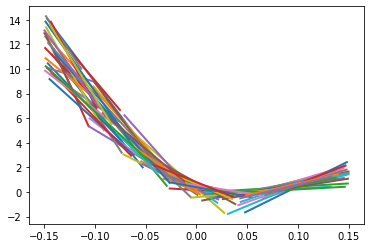

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
from sklearn.linear_model import LinearRegression


def fit_linear_segment(x, y):
    
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    return model.coef_[0], model.intercept_


def fit_constrained_segment(x, y, split_point, y_constraint):
    
    x_centered = x - split_point
    slope = np.sum(x_centered * (y - y_constraint)) / np.sum(x_centered ** 2)
    intercept = y_constraint - slope * split_point
    return slope, intercept


def process_hour(load_variation_dir, hour_dir, hour, output_dir, results_list):
    
    
    
    load_variation_file = os.path.join(load_variation_dir, f'load_variation_divided_{hour}.csv')
    cost_differences_file = os.path.join(hour_dir, str(hour), 'divided_costs.csv')
    if not os.path.exists(load_variation_file) or not os.path.exists(cost_differences_file):
        print(f"file {load_variation_file} or {cost_differences_file} not exist, skip Hour {hour}。")
        return
    load_variation_data = pd.read_csv(load_variation_file)
    cost_differences_data = pd.read_csv(cost_differences_file)
    
    x = load_variation_data.values.flatten()
    y = cost_differences_data.values.flatten()
    sort_indices = np.argsort(x)
    x_sorted = x[sort_indices]
    y_sorted = y[sort_indices]
    
    breakpoints_df = pd.read_csv('./optimal_segments_breakpoints.csv')
    breakpoints_row = breakpoints_df[breakpoints_df['Hour'] == hour]
    if breakpoints_row.empty or 'Breakpoints' not in breakpoints_row.columns:
        print(f"Hour {hour} not exist, skip")
        return
    
    breakpoints_str = breakpoints_row['Breakpoints'].values[0]
    try:
        if isinstance(breakpoints_str, str):
            breakpoints_str = breakpoints_str.strip('[]').replace('\n', ' ').strip()
            breakpoints = list(map(float, breakpoints_str.split()))
        else:
            breakpoints = list(breakpoints_str)
    except Exception as e:
        return
    breakpoints = [-np.inf] + breakpoints + [np.inf]  
    
    
    merged_breakpoints = []
    i = 0
    while i < len(breakpoints) - 1:
        start = breakpoints[i]
        end = breakpoints[i + 1]
        x_segment = x_sorted[(x_sorted > start) & (x_sorted <= end)]
        y_segment = y_sorted[(x_sorted > start) & (x_sorted <= end)]
        
        
        while len(x_segment) < 5 and i < len(breakpoints) - 2:
            i += 1
            end = breakpoints[i + 1]
            x_segment = x_sorted[(x_sorted > start) & (x_sorted <= end)]
            y_segment = y_sorted[(x_sorted > start) & (x_sorted <= end)]
        
        merged_breakpoints.append(end)
        i += 1
    
    
    breakpoints = [-np.inf] + merged_breakpoints + [np.inf]
    
    
    segment_results = []
    
    # plt.figure(figsize=(10, 6))
    # plt.scatter(x_sorted, y_sorted, color='blue', label='原始数据', alpha=0.5)
    
    prev_y = None
    for i in range(len(breakpoints) - 1):
        x_segment = x_sorted[(x_sorted > breakpoints[i]) & (x_sorted <= breakpoints[i + 1])]
        y_segment = y_sorted[(x_sorted > breakpoints[i]) & (x_sorted <= breakpoints[i + 1])]
        if len(x_segment) > 1:  
            if prev_y is not None:
                slope, intercept = fit_constrained_segment(x_segment, y_segment, breakpoints[i], prev_y)
            else:
                slope, intercept = fit_linear_segment(x_segment, y_segment)
            
            segment_results.append([hour, i + 1, breakpoints[i], breakpoints[i + 1], slope, intercept])
            
            x_fit = np.linspace(min(x_segment), max(x_segment), 100)
            y_fit = slope * x_fit + intercept
            plt.plot(x_fit, y_fit, label=f'Segment {i+1}', linewidth=2)
            
            prev_y = slope * breakpoints[i + 1] + intercept
        else:
            print(f"Hour {hour} in {breakpoints[i + 1]} skip")
    
    # plt.title(f'Hour {hour} - Piecewise Linear Fit (Continuous)')
    # plt.xlabel('Load Deviation')
    # plt.ylabel('Cost Deviation')
    # plt.legend()
    # plt.grid(True)
    
    # os.makedirs(output_dir, exist_ok=True)
    # plot_file = os.path.join(output_dir, f'hour_{hour}_piecewise_fit_continuous.png')
    # plt.savefig(plot_file)
    # plt.close()
    
    results_list.extend(segment_results)


def process_all_hours(load_variation_dir, hour_dir, output_dir, output_csv):
    
    results_list = []
    
    for hour in range(1, 25):
        process_hour(load_variation_dir, hour_dir, hour, output_dir, results_list)
    
    results_df = pd.DataFrame(results_list, columns=['Hour', 'Segment', 'Breakpoint_Start', 'Breakpoint_End', 'Slope', 'Intercept'])
    results_df.to_csv(output_csv, index=False)


load_variation_dir = './load_variation'
hour_dir = './hour'
output_dir = './piecewise_linear_plots_continuous'
output_csv = './piecewise_linear_fit_results_continuous.csv'


process_all_hours(load_variation_dir, hour_dir, output_dir, output_csv)

In [3]:
import pandas as pd
import os

def split_test_data_by_hour(X_test_file, Y_test_file, output_folder, start_hour=7):
    
    X_test = pd.read_csv(X_test_file)
    Y_test = pd.read_csv(Y_test_file)

    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    
    for hour in range(24):
        
        actual_hour = (start_hour - 1 + hour) % 24 + 1

        
        extracted_X = X_test.iloc[hour::24, :]
        extracted_Y = Y_test.iloc[hour::24, :]

        
        extracted_X.to_csv(f'{output_folder}/X_test_hour_{actual_hour}.csv', index=False)
        extracted_Y.to_csv(f'{output_folder}/Y_test_hour_{actual_hour}.csv', index=False)



def main():
    
    X_test_file = 'X_test.csv'
    Y_test_file = 'Y_test.csv'

    
    output_folder = './test_split'

    
    split_test_data_by_hour(X_test_file, Y_test_file, output_folder, start_hour=7)


main()

In [4]:
import numpy as np
import pandas as pd

def smooth_segment(breakpoint, slope_left, intercept_left, slope_right, intercept_right, delta=0.0001):
    
    x_left = breakpoint - delta
    x_right = breakpoint + delta
    
    
    y_left = slope_left * x_left + intercept_left
    dy_left = slope_left
    
    
    y_right = slope_right * x_right + intercept_right
    dy_right = slope_right
    
    
    A = np.array([[x_left**2, x_left, 1],
                  [x_right**2, x_right, 1],
                  [2 * x_left, 1, 0],
                  [2 * x_right, 1, 0]])
    b = np.array([y_left, y_right, dy_left, dy_right])
    
    
    a, b, c = np.linalg.lstsq(A, b, rcond=None)[0]
    
    
    y_left_curve = a * x_left**2 + b * x_left + c
    y_right_curve = a * x_right**2 + b * x_right + c
    dy_left_curve = 2 * a * x_left + b
    dy_right_curve = 2 * a * x_right + b
    
    assert np.isclose(y_left_curve, y_left), "Left value condition not satisfied"
    assert np.isclose(y_right_curve, y_right), "Right value condition not satisfied"
    assert np.isclose(dy_left_curve, dy_left), "Left derivative condition not satisfied"
    assert np.isclose(dy_right_curve, dy_right), "Right derivative condition not satisfied"
    
    return a, b, c

def smooth_breakpoints(results_df, delta=0.0001):
    
    smoothed_results = []
    
    
    for hour in range(1, 25):
        hour_df = results_df[results_df['Hour'] == hour]
        
        for i in range(len(hour_df) - 1):
            segment_left = hour_df.iloc[i]
            segment_right = hour_df.iloc[i + 1]
            
            
            breakpoint_left = segment_left['Breakpoint_End']
            breakpoint_right = segment_right['Breakpoint_Start']
            
            
            if breakpoint_left == breakpoint_right and not np.isinf(breakpoint_left):
                
                slope_left = segment_left['Slope']
                intercept_left = segment_left['Intercept']
                slope_right = segment_right['Slope']
                intercept_right = segment_right['Intercept']
                
                
                a, b, c = smooth_segment(breakpoint_left, slope_left, intercept_left, slope_right, intercept_right, delta)
                
                
                smoothed_results.append([hour, breakpoint_left, a, b, c])
    
    
    smoothed_df = pd.DataFrame(smoothed_results, columns=['Hour', 'Breakpoint', 'A', 'B', 'C'])
    smoothed_df.to_csv('./smooth_breakpoints_results.csv', index=False)


results_df = pd.read_csv('./piecewise_linear_fit_results_continuous.csv')


smooth_breakpoints(results_df)

In [5]:
import numpy as np
import pandas as pd
import os


fit_results_path = './piecewise_linear_fit_results_continuous.csv'  
smooth_results_path = './smooth_breakpoints_results.csv'  
output_dir = './predictions'  
model_params_dir = './model_params'  
epsilon_dir = './epsilon_values'  
hourly_data_dir = './hourly_data'
test_data_dir = './test_split'  

os.makedirs(output_dir, exist_ok=True)
os.makedirs(model_params_dir, exist_ok=True)
os.makedirs(epsilon_dir, exist_ok=True)


fit_results_df = pd.read_csv(fit_results_path)
smooth_results_df = pd.read_csv(smooth_results_path)


delta = 0.0001  # 分段阈值
gamma = 0.0001  # 学习率衰减率
max_iter = 1000  # 最大迭代次数
alpha = 0.01  # 岭回归的正则化强度


def piecewise_gradient(epsilon_i, delta, a_k, breakpoints, smooth_results_hour):
    
    grad = 0
    segment_index = np.digitize([epsilon_i], breakpoints)[0] - 1  
    segment_index = int(np.clip(segment_index, 0, len(a_k) - 1))  
    
    if np.abs(epsilon_i - breakpoints[segment_index]) < delta:
        
        smooth_params = smooth_results_hour[smooth_results_hour['Breakpoint'] == breakpoints[segment_index]]
        if not smooth_params.empty:
            a_quad = smooth_params['A'].values[0]
            b_quad = smooth_params['B'].values[0]
            
            grad = 2 * a_quad * epsilon_i + b_quad
    else:
        
        grad = a_k[segment_index]
    return grad


def evaluate(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    return mse, rmse, mae


def calculate_mape(y_true, y_pred):
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def combine_and_sort_predictions(all_predictions, all_trends):
    
    combined_df = pd.DataFrame({
        'trend': np.concatenate(all_trends),
        'prediction': np.concatenate(all_predictions)
    })
    
    sorted_df = combined_df.sort_values(by='trend')
    return sorted_df['prediction'].values


def train_and_predict_hour(hour):
    
    fit_results_hour = fit_results_df[fit_results_df['Hour'] == hour]
    a_k = fit_results_hour['Slope'].values  
    breakpoints = fit_results_hour['Breakpoint_Start'].values 
    
    smooth_results_hour = smooth_results_df[smooth_results_df['Hour'] == hour]
    
    X_train_file = os.path.join(hourly_data_dir, f'X_train_hour_{hour}.csv')
    Y_train_file = os.path.join(hourly_data_dir, f'Y_train_hour_{hour}.csv')
    X_test_file = os.path.join(test_data_dir, f'X_test_hour_{hour}.csv')
    Y_test_file = os.path.join(test_data_dir, f'Y_test_hour_{hour}.csv')
    X_train = pd.read_csv(X_train_file).values
    y_train = pd.read_csv(Y_train_file).values.reshape(-1, 1)
    X_test = pd.read_csv(X_test_file)
    y_test = pd.read_csv(Y_test_file).values.reshape(-1, 1)
    
    X_train_min = np.min(X_train, axis=0)
    X_train_max = np.max(X_train, axis=0)
    X_train = 2 * (X_train - X_train_min) / (X_train_max - X_train_min) - 1
    X_test_values = 2 * (X_test.values - X_train_min) / (X_train_max - X_train_min) - 1
    
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_test_values = np.hstack([X_test_values, np.ones((X_test_values.shape[0], 1))])
    
    n, d = X_train.shape
    w = np.zeros((d, 1))
    eta = 30  
    
    for t in range(1, max_iter + 1):
        grad_w = np.zeros_like(w)
        for i in range(n):  
            epsilon_i = (X_train[i] @ w - y_train[i]) / y_train[i]
            grad_L_i = piecewise_gradient(epsilon_i, delta, a_k, breakpoints, smooth_results_hour)
            grad_w += (grad_L_i / y_train[i]) * X_train[i].reshape(-1, 1)
        
        grad_w += alpha * w / n
        w -= eta * grad_w  
        eta = eta / (1 + gamma * t)  
       
        if t % 100 == 0:
            y_pred_train = X_train @ w
            mse_train, _, _ = evaluate(y_train, y_pred_train)
            print(f"Hour {hour}, iteration {t}: trainning set MSE={mse_train:.4f}")
            np.save(os.path.join(model_params_dir, f'w_hour_{hour}_iter_{t}.npy'), w)
    
    y_pred_train = X_train @ w
    y_pred_test = X_test_values @ w
    
    mse_train, rmse_train, mae_train = evaluate(y_train, y_pred_train)
    mse_test, rmse_test, mae_test = evaluate(y_test, y_pred_test)
    print(f"Hour {hour} final trainning set: MSE={mse_train:.4f}, RMSE={rmse_train:.4f}, MAE={mae_train:.4f}")
    print(f"Hour {hour} final testing set: MSE={mse_test:.4f}, RMSE={rmse_test:.4f}, MAE={mae_test:.4f}")
    
    pd.DataFrame({"y_true": y_train.flatten(), "y_pred": y_pred_train.flatten()}).to_csv(
        os.path.join(output_dir, f'predictions_train_hour_{hour}.csv'), index=False)
    pd.DataFrame({"y_true": y_test.flatten(), "y_pred": y_pred_test.flatten()}).to_csv(
        os.path.join(output_dir, f'predictions_test_hour_{hour}.csv'), index=False)
    
    np.save(os.path.join(model_params_dir, f'w_hour_{hour}_final.npy'), w)
    
    return y_pred_test.flatten(), X_test['trend'].values


all_predictions = []
all_trends = []
for hour in range(1, 25):
    y_pred, trend = train_and_predict_hour(hour)
    all_predictions.append(y_pred)
    all_trends.append(trend)
    print(f"Hour {hour} compelete")

sorted_predictions = combine_and_sort_predictions(all_predictions, all_trends)


pd.DataFrame({"sorted_predictions": sorted_predictions}).to_csv(
    os.path.join(output_dir, 'prediction_GB.csv'), index=False)

final_predictions = pd.read_csv(os.path.join(output_dir, 'prediction_GB.csv'))
y_test = pd.read_csv(os.path.join('Y_test.csv')).values.flatten()

assert len(final_predictions) == len(y_test), "not the same length"

y_pred = final_predictions['sorted_predictions'].values


mse = np.mean((y_test - y_pred) ** 2)
rmse = np.sqrt(mse)
mape = calculate_mape(y_test, y_pred)


print(f"Final RMSE: {rmse:.4f}")
print(f"Final MAPE: {mape:.4f}%")

Hour 1, iteration 100: trainning set MSE=70251.7996
Hour 1, iteration 200: trainning set MSE=67608.9085
Hour 1, iteration 300: trainning set MSE=67253.0024
Hour 1, iteration 400: trainning set MSE=67226.0924
Hour 1, iteration 500: trainning set MSE=67225.3821
Hour 1, iteration 600: trainning set MSE=67225.3764
Hour 1, iteration 700: trainning set MSE=67225.3763
Hour 1, iteration 800: trainning set MSE=67225.3763
Hour 1, iteration 900: trainning set MSE=67225.3763
Hour 1, iteration 1000: trainning set MSE=67225.3763
Hour 1 final trainning set: MSE=67225.3763, RMSE=259.2786, MAE=223.6232
Hour 1 final testing set: MSE=130558.3741, RMSE=361.3286, MAE=330.5911
Hour 1 compelete
Hour 2, iteration 100: trainning set MSE=30723.1430
Hour 2, iteration 200: trainning set MSE=27996.6244
Hour 2, iteration 300: trainning set MSE=27817.2282
Hour 2, iteration 400: trainning set MSE=27802.5358
Hour 2, iteration 500: trainning set MSE=27802.1643
Hour 2, iteration 600: trainning set MSE=27802.1603
Hour 2,